In [30]:
import sys
import math

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
import lightning as L

from dal_toolbox.models.utils.random_features import RandomFeatureGaussianProcess
from dal_toolbox.models.utils.spectral_normalization import spectral_norm_linear

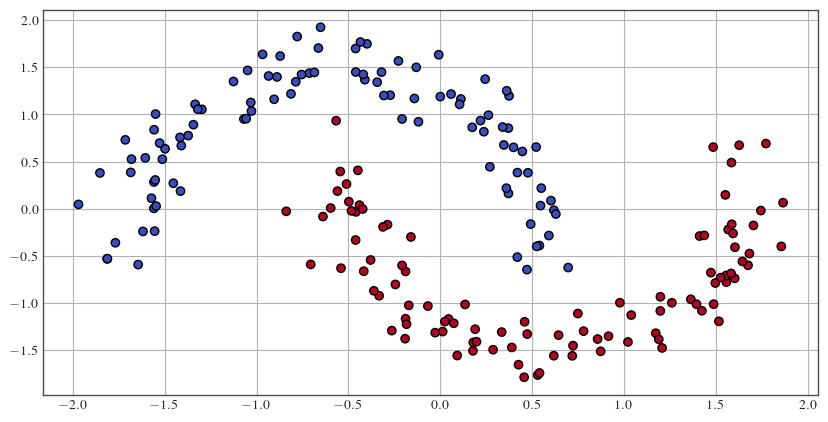

In [31]:
X, y = datasets.make_moons(200, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [32]:
from dal_toolbox.models.sngp.base import SNGPModule
from dal_toolbox.models.utils.callbacks import MetricsHistory

    
class Model(SNGPModule):
    def __init__(self,
                 num_classes: int,
                 use_spectral_norm: bool = True,
                 spectral_norm_params: dict = {},
                 gp_params: dict = {},
                 n_residual_layers: int = 6,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        def linear_layer(*args, **kwargs):
            if use_spectral_norm:
                return spectral_norm_linear(nn.Linear(*args, **kwargs), **spectral_norm_params)
            else:
                return nn.Linear(*args, **kwargs)

        self.first = nn.Linear(2, feature_dim)
        self.residuals = nn.ModuleList([linear_layer(128, 128) for _ in range(n_residual_layers)])
        self.last = RandomFeatureGaussianProcess(
            in_features=feature_dim,
            out_features=num_classes,
            **gp_params,
        )
        self.act = nn.ReLU()

    def forward(self, x, mean_field=False, return_cov=False):
        # : Added activation to first layer
        x = self.act(self.first(x))
        for residual in self.residuals:
            x = self.act(residual(x) + x)

        if mean_field:
            out = self.last.forward_mean_field(x)
        else:
            out = self.last(x, return_cov=return_cov)

        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-2, weight_decay=1e-2, momentum=.9)
        return optimizer
    

In [33]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz, mean_field=True)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                         | Params
-----------------------------------------------------------
0 | first     | Linear                       | 384   
1 | residuals | ModuleList                   | 99.1 K
2 | last      | RandomFeatureGaussianProcess | 2.0 K 
3 | act       | ReLU                         | 0     
-----------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 106.30it/s, v_num=94]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 65.99it/s, v_num=94] 


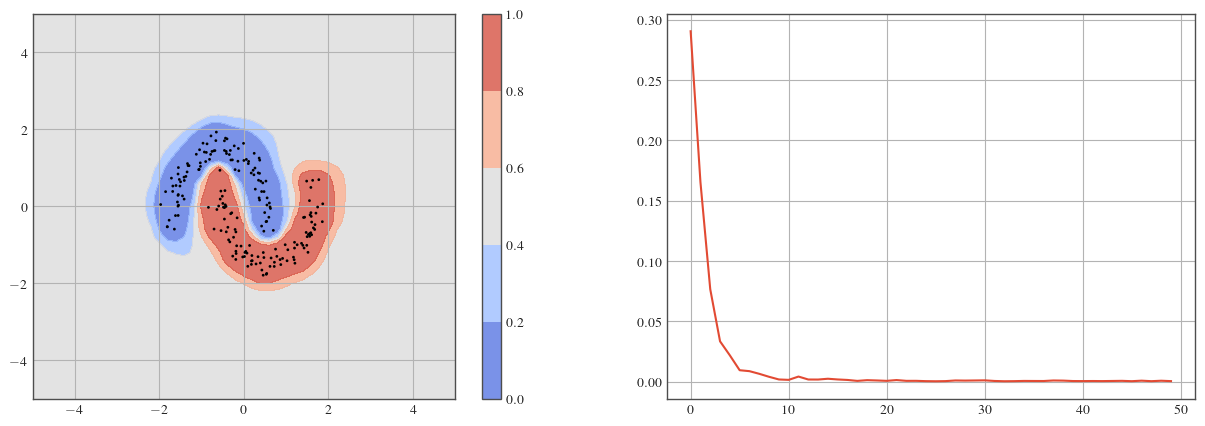

In [34]:
spectral_norm_params = dict(
    norm_bound=.9,
    n_power_iterations=1
)
gp_params = dict(
    num_inducing=1024,
    kernel_scale=0.05,
    random_feature_type='orf',
    scale_random_features=False,
    # normalize_input=False,
    # mean_field_factor=1,
    # cov_momentum=-1,
    # ridge_penalty=1
)
epochs = 50

torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = Model(num_classes=2, use_spectral_norm=True, spectral_norm_params=spectral_norm_params, gp_params=gp_params)
history = MetricsHistory()
trainer = L.Trainer(max_epochs=epochs, callbacks=[history])
trainer.fit(model, train_loader)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(model, X, y)
plt.subplot(122)
plt.plot([d['loss'] for d in history])
plt.show()